In [1]:
# dependencies
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import zarr
import dask

from fastjmd95 import jmd95numba 
from xhistogram.xarray import histogram
from pathlib import Path

In [2]:
# first define a helper function to rotate plots for N-S/vertical alignment
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

# function to get i,j indices from target lat/lon vals
def i_j_from_lat_lon(coord_centers, num_boxes, coord_min):
    i = []
    j = []
    for box in range(int(num_boxes)):
        # get lat/lon in increments
        target = coord_min + 0.1 * box

        # get index closest to lat/lon targets
        dist = np.abs(coord_centers - target)
        flat_idx = np.nanargmin(dist)
        i_, j_ = np.unravel_index(flat_idx, coord_centers.shape)
        
        i.append(int(i_)), j.append(int(j_))
    return i, j

# function to get lat/lon vals from i, j indices
def lat_lon_from_i_j(LLC):
    lats = []
    lons = []
    lats.append(LLC['YC'][0,:].values)
    lons.append(LLC['XC'][:,0].values)

    return lats, lons

In [3]:
data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'
data1 = 'MLD_test_face7_(432,9192)_((2000, 2540))'
data2 ='MLD_2_face7_(2640,3384)_0.25_((2000, 2540))'
data3 = 'MLD_3_face7_(2640,3384)_0.25_((2000, 2540))'
MLD_1 = xr.open_zarr(f'{data_dir}/{data1}.zarr',consolidated=False)
MLD_2 = xr.open_zarr(f'{data_dir}/{data2}.zarr',consolidated=False)
MLD_3 = xr.open_zarr(f'{data_dir}/{data3}.zarr',consolidated=False)
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

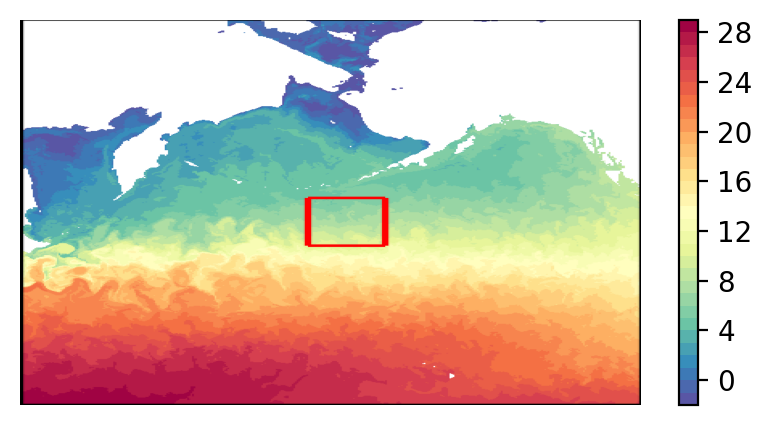

In [ ]:
t1 = MLD_1.isel(time=0)
# extract box i,j extents
i_0 = t1.i.values.min()
i_1 = t1.i.values.max()
j_0 = t1.j.values.min()
j_1 = t1.j.values.max()

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=7, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

In [5]:
# take temporal average of MLD1, grab jan
MLD_jan = MLD_1.resample(time="MS").mean().isel(time=3).compute()

In [6]:
# subset into tiles:
"""
SUBSET INTO TILES
"""

# subset into tiles, weight by surface area   
tile_width = 0.25
YC = MLD_jan.YC 
XC = MLD_jan.XC 
lat_min = float(YC.min()) 
lat_max = float(YC.max()) 
lon_min = float(XC.min()) 
lon_max = float(XC.max())

# compute tile labels eagerly (small arrays)
tile_lat = ((MLD_jan.YC - lat_min) / tile_width).astype("int32").compute()
tile_lon = ((MLD_jan.XC - lon_min) / tile_width).astype("int32").compute()

# stack dataset
MLD_1_tile = MLD_jan.assign_coords(
    tile_lat=tile_lat,
    tile_lon=tile_lon,
).stack(cell=("j","i"))

# stack area
area_cell = MLD_jan.rA.stack(cell=("j","i"))

# attach tile labels to area
area_cell = area_cell.assign_coords(
    tile_lat=MLD_1_tile.tile_lat,
    tile_lon=MLD_1_tile.tile_lon,
)

num = (MLD_1_tile * area_cell).groupby(["tile_lat","tile_lon"]).sum("cell")
den = area_cell.groupby(["tile_lat","tile_lon"]).sum("cell")

MLD_1_tiles = num / den
MLD_1_pixels = MLD_jan

In [7]:
MLD_2 = MLD_2.isel(time=0)
MLD_3 = MLD_3.isel(time=0)

In [8]:
MLD_1

<xarray.Dataset> Size: 10GB
Dimensions:     (time: 8760, j: 540, i: 540)
Coordinates:
  * j           (j) int16 1kB 2000 2001 2002 2003 2004 ... 2536 2537 2538 2539
    face        int16 2B ...
  * time        (time) datetime64[ns] 70kB 2011-10-01 ... 2012-09-29T23:00:00
  * i           (i) int16 1kB 2000 2001 2002 2003 2004 ... 2536 2537 2538 2539
Data variables:
    MLD_pixels  (time, j, i) float32 10GB dask.array<chunksize=(96, 384, 384), meta=np.ndarray>
    YC          (j, i) float32 1MB dask.array<chunksize=(304, 304), meta=np.ndarray>
    rA          (j, i) float32 1MB dask.array<chunksize=(304, 304), meta=np.ndarray>
    XC          (j, i) float32 1MB dask.array<chunksize=(304, 304), meta=np.ndarray>

In [9]:
MLD_2

<xarray.Dataset> Size: 1MB
Dimensions:     (tile_lat: 29, tile_lon: 45, j: 540, i: 540)
Coordinates:
  * tile_lat    (tile_lat) int32 116B 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28
    time        datetime64[ns] 8B 2012-01-01
    face        int16 2B ...
  * i           (i) int16 1kB 2000 2001 2002 2003 2004 ... 2536 2537 2538 2539
  * j           (j) int16 1kB 2000 2001 2002 2003 2004 ... 2536 2537 2538 2539
  * tile_lon    (tile_lon) int32 180B 0 1 2 3 4 5 6 7 ... 38 39 40 41 42 43 44
Data variables:
    YC          (tile_lat, tile_lon) float32 5kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    rA          (j, i) float32 1MB dask.array<chunksize=(384, 384), meta=np.ndarray>
    MLD_pixels  (tile_lat, tile_lon) float32 5kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    XC          (tile_lat, tile_lon) float32 5kB dask.array<chunksize=(1, 1), meta=np.ndarray>

In [10]:
MLD_3

<xarray.Dataset> Size: 1MB
Dimensions:     (tile_lat: 29, tile_lon: 45, j: 540, i: 540)
Coordinates:
  * tile_lon    (tile_lon) int32 180B 0 1 2 3 4 5 6 7 ... 38 39 40 41 42 43 44
  * tile_lat    (tile_lat) int32 116B 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28
  * j           (j) int16 1kB 2000 2001 2002 2003 2004 ... 2536 2537 2538 2539
    time        datetime64[ns] 8B 2012-01-01
  * i           (i) int16 1kB 2000 2001 2002 2003 2004 ... 2536 2537 2538 2539
    face        int16 2B ...
Data variables:
    XC          (tile_lat, tile_lon) float32 5kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    rA          (j, i) float32 1MB dask.array<chunksize=(384, 384), meta=np.ndarray>
    YC          (tile_lat, tile_lon) float32 5kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    MLD_pixels  (tile_lat, tile_lon) float32 5kB dask.array<chunksize=(1, 1), meta=np.ndarray>

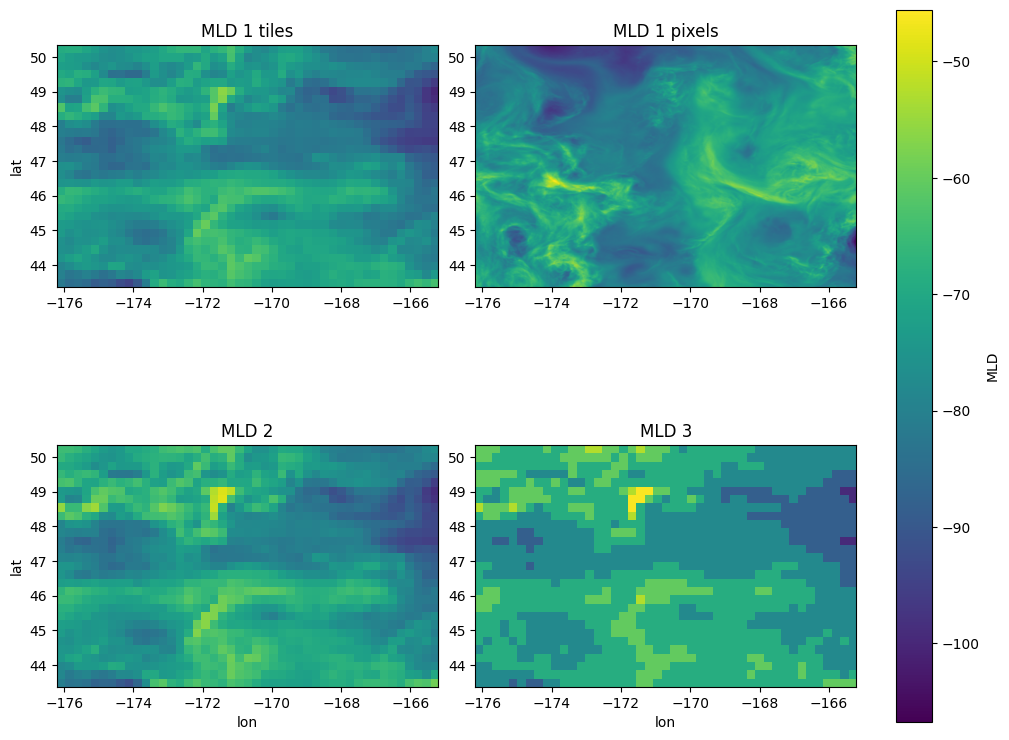

In [ ]:
vmin = np.min([
    MLD_1_tiles.MLD_pixels.min(),
    MLD_1_pixels.MLD_pixels.min(),
    MLD_2.MLD_pixels.min(),
    MLD_3.MLD_pixels.min()
])

vmax = np.max([
    MLD_1_tiles.MLD_pixels.max(),
    MLD_1_pixels.MLD_pixels.max(),
    MLD_2.MLD_pixels.max(),
    MLD_3.MLD_pixels.max()
])

fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

# Physical coordinates on axes (assuming same grid for all)
extent = [MLD_1_tiles.XC.min(), MLD_1_tiles.XC.max(),
          MLD_1_tiles.YC.min(), MLD_1_tiles.YC.max()]

# Row 1
im0 = axes[0, 0].imshow(MLD_1_tiles.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[0, 0].set_title("MLD 1 tiles")

im1 = axes[0, 1].imshow(MLD_1_pixels.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[0, 1].set_title("MLD 1 pixels")

# Row 2
im2 = axes[1, 0].imshow(MLD_2.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[1, 0].set_title("MLD 2")

im3 = axes[1, 1].imshow(MLD_3.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[1, 1].set_title("MLD 3")

# Shared colorbar (use last handle)
cbar = fig.colorbar(im3, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label("MLD")

# Axis labels (only outer to keep clean)
for ax in axes[1, :]:
    ax.set_xlabel("lon")
for ax in axes[:, 0]:
    ax.set_ylabel("lat")

plt.show()

In [ ]:
data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'
data1 = 'MLD_1_face1_(432,9192)_(Agulhas)'
data2 ='MLD_2_face1_(432,9192)_(Agulhas)'
data3 = 'MLD_3_face1_(432,9192)_(Agulhas)'
MLD_1 = xr.open_zarr(f'{data_dir}/{data1}.zarr',consolidated=False)
MLD_2 = xr.open_zarr(f'{data_dir}/{data2}.zarr',consolidated=False)
MLD_3 = xr.open_zarr(f'{data_dir}/{data3}.zarr',consolidated=False)
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

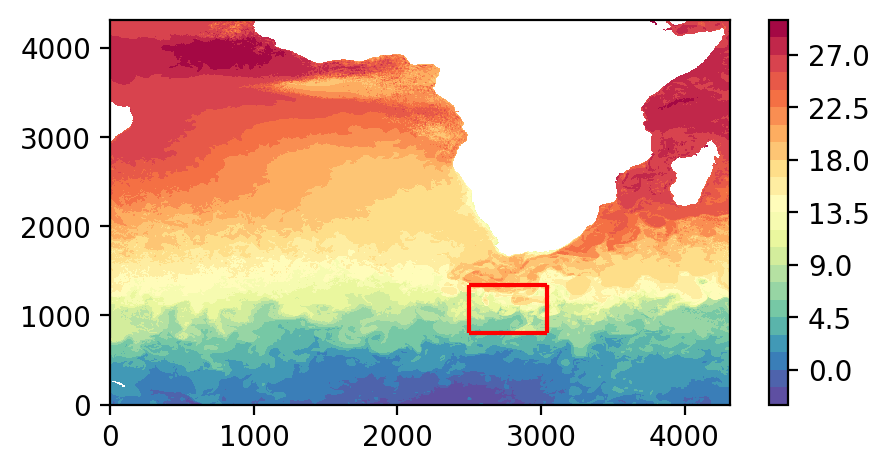

In [16]:
t1 = MLD_1.isel(time=0)
# extract box i,j extents
j_0 = 800
j_1 = j_0 + 540
i_0 = 2500
i_1 = i_0 + 540

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=1, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

plt.show()